In [2]:
from PIL import Image
import os

image = Image.open('Testing/CityUncompressed.jpg')

width, height = image.size
new_size = (width//2, height//2)
resized_image = image.resize(new_size)

resized_image.save('compressed_image.jpg', optimize=True, quality=50)

original_size = os.path.getsize('Testing/CityUncompressed.jpg')
compressed_size = os.path.getsize('compressed_image.jpg')

print("Original Size: ", original_size)
print("Compressed Size: ", compressed_size)

Original Size:  9011
Compressed Size:  943


In [1]:
class ImageCompressor:
    """
    Image Compressor is a custom-built class that compresses an image by resizing it to any new dimensions
    and saving it with a specified compression format.
    
    ----------------------------------------------
    Parameters:
    width: int
        The new width of the image.
        
    height: int 
        The new height of the image.
    """
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.new_size = (self.width, self.height)
    
    def compress(self, image_path, new_path, compression_type, quality=50):
        """
        Compresses an image by resizing it to the new dimensions and saving it with the specified compression format.
        
        ----------------------------------------------
        Parameters:
        image_path: str
            The path to the image that needs to be compressed.
            
        new_path: str
            The path to save the compressed image.
            
        compression_type: str
            The compression format to save the image in. 
            Example: 'JPEG', 'PNG', 'WEBP'
        """
        image = Image.open(image_path)
        resized_image = image.resize(self.new_size)
        resized_image.save(new_path, optimize=True, quality=quality, format=compression_type)
        return 
    
    def get_size(self, image_path):
        """
        Returns the size of the image in bytes.
        
        ----------------------------------------------
        Parameters:
        image_path: str
            The path to the image.
        """
        return os.path.getsize(image_path)
    def upscale(self, image_path, new_path, og_size):
        """
        Uncompresses an image by resizing it to the original dimensions and saving it in the original format.
        
        ----------------------------------------------
        Parameters:
        image_path: str
            The path to the image that needs to be uncompressed.
            
        new_path: str
            The path to save the uncompressed image.
        
        og_size: tuple
            The original dimensions of the image.
        """
        image = Image.open(image_path)
        resized_image = image.resize(og_size)
        resized_image.save(new_path, optimize=True, quality=100)
        return

    def pipeline(self, ref_image_path, comp_image_path, width, height, compression_type, quality):
        """
        A pipeline that compresses an image, calculates the Mean Squared Error (MSE), Peak Signal to Noise Ratio (PSNR), Structural 
        Similarity Index (SSIM), and Multi-Scale Structural Similarity Index (MS-SSIM) between the reference image and the compressed image.
        
        ----------------------------------------------
        Parameters:
        ref_image_path: str
            The path to the reference image.
            
        comp_image_path: str
            The path to the compressed image.
            
        width: int
            The new width of the image.
            
        height: int
            The new height of the image.
            
        compression_type: str
            The compression format to save the image in. 
            Example: 'JPEG', 'PNG', 'WEBP'
        """
        compressor = ImageCompressor(width, height)
        compressor.compress(ref_image_path, comp_image_path, compression_type, quality)

        metrics = ImageQualityMetrics(ref_image_path, comp_image_path)
        mse = metrics.calculate_mse()
        psnr = metrics.calculate_psnr()
        ssim = metrics.calculate_ssim()
        msssim = metrics.calculate_msssim()
        image_size = compressor.get_size(comp_image_path)

        return [mse, psnr, ssim, msssim, image_size]

In [30]:
import numpy as np
from PIL import Image
from skimage.metrics import structural_similarity as compare_ssim
import cv2

class ImageQualityMetrics:
    """
    ImageQualityMetrics is a custom-built class that calculates the Mean Squared Error (MSE) and the Peak Signal to Noise Ratio (PSNR)
    between a reference image and a compressed image.
    
    ----------------------------------------------
    Parameters:
        
    ref_image_path: str
        The path to the reference image.
        
    comp_image_path: str
        The path to the compressed image.
        
    """
    def __init__(self, ref_image_path, comp_image_path, im_up = True):
        self.ref_image = np.array(Image.open(ref_image_path))
        if im_up:
            ImageCompressor.upscale(self, comp_image_path, 'uncompressed_image.jpg', [self.ref_image.shape[1],self.ref_image.shape[0]])
            self.comp_image = np.array(Image.open('uncompressed_image.jpg'))
        else: 
            self.comp_image = np.array(Image.open(comp_image_path))
        
    def calculate_mse(self):
        """
        Calculates the Mean Squared Error (MSE) between the reference image and the compressed image.
        """
        err = np.sum((self.ref_image.astype("float") - self.comp_image.astype("float")) ** 2)
        err /= float(self.ref_image.shape[0] * self.ref_image.shape[1])
        return err

    def calculate_psnr(self):
        """
        Calculates the Peak Signal to Noise Ratio (PSNR) between the reference image and the compressed image.
        """
        mse = self.calculate_mse()
        if mse == 0:
            return 100
        PIXEL_MAX = 255.0
        return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

    def calculate_ssim(self):
        """
        Calculates the Structural Similarity Index (SSIM) between the reference image and the compressed image.  
        """
        img1 = cv2.cvtColor(self.ref_image, cv2.COLOR_BGR2GRAY)
        img2 = cv2.cvtColor(self.comp_image, cv2.COLOR_BGR2GRAY)
        return compare_ssim(img1, img2)
        
    def calculate_msssim(self):
        """
        Calculates the Multi-Scale Structural Similarity Index (MS-SSIM) between the reference image and the compressed image.
        """
        img1 = cv2.cvtColor(self.ref_image, cv2.COLOR_BGR2GRAY)
        img2 = cv2.cvtColor(self.comp_image, cv2.COLOR_BGR2GRAY)
        return compare_ssim(img1, img2, multichannel=True, gaussian_weights=True, sigma=1.5, use_sample_covariance=False)
    


In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt

class ImageProcessor:
    """
    ImageProcessor is a custom-built class that processes a directory of images by compressing them to a specified size and quality then analyses them utilizing the helper classes ImageCompressor and ImageQualityMetrics.
    
    ----------------------------------------------
    Parameters:
        
    directory_path: str
        The path to the directory containing the images to be processed.
        
    compressed_path: str
        The path to the directory where the compressed images will be saved.
    """
    def __init__(self, directory_path, compressed_path):
        self.directory_path = directory_path
        self.compressed_path = compressed_path
        self.image_files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

    def process_images(self, width, height, compression_type, quality):
        """
        Processes the images in the directory by compressing them to the specified size and quality, then calculates the Mean Squared Error (MSE), Peak Signal to Noise Ratio (PSNR), Structural Similarity Index (SSIM), and Multi-Scale Structural Similarity Index (MS-SSIM) between the reference image and the compressed image.
        
        ----------------------------------------------
        Parameters:
        
        width: int
            The new width of the image.
            
        height: int
            The new height of the image.
            
        compression_type: str
            The compression format to save the image in. 
            Example: 'JPEG', 'PNG', 'WEBP'
            
        quality: int
            The quality of the compressed image.
        """
        results = []
        for image_file in self.image_files:
            ref_image_path = os.path.join(self.directory_path, image_file)
            comp_image_path = os.path.join(self.compressed_path, 'compressed_' + image_file)
            compressor = ImageCompressor(width, height)
            metrics = compressor.pipeline(ref_image_path, comp_image_path, width, height, compression_type, quality)
            results.append([image_file] + metrics + [compression_type, quality])
        self.df = pd.DataFrame(results, columns=['Image', 'MSE', 'PSNR', 'SSIM', 'MS-SSIM', 'Size', 'Compression Type', 'Quality'])

    def save_to_csv(self, csv_file_path):
        """
        Saves the processed image data to a CSV file.
        
        ----------------------------------------------
        Parameters:
        
        csv_file_path: str
            The path to save the CSV file.
        """
        self.df.to_csv(csv_file_path, index=False)

    def plot_metrics(self, csv_file_path):
        """
        Plots the metrics for each image in the CSV file.
        
        ----------------------------------------------
        
        Parameters:
            
        csv_file_path: str
            The path to the CSV file containing the image data.
        """
        df = pd.read_csv(csv_file_path)
        compression_types = df['Compression Type'].unique()

        for compression_type in compression_types:
            df_type = df[df['Compression Type'] == compression_type]

            plt.figure(figsize=(10, 6))
            plt.plot(df_type['MSE'], label='MSE')
            plt.plot(df_type['PSNR'], label='PSNR')
            plt.plot(df_type['SSIM'], label='SSIM')
            plt.plot(df_type['MS-SSIM'], label='MS-SSIM')
            plt.plot(df_type['Size'], label='Size')
            plt.title(f'Metrics for {compression_type} Compression')
            plt.xlabel('Image')
            plt.ylabel('Value')
            plt.legend()
            plt.show()

    def clear_data(self, csv_file_path):
        self.df = pd.DataFrame()
        self.df.to_csv(csv_file_path, index=False)

In [4]:
import os
import glob

def delete_compressed_files(directories):
    for directory in directories:
        # Use glob to find all files in the directory with the prefix 'compressed_'
        files = glob.glob(os.path.join(directory, 'compressed_*'))
        for file in files:
            # Use os.remove to delete each file
            os.remove(file)

# List of directories to search
directories = ['Testing', 'Compressed']

# Call the function with the list of directories
delete_compressed_files(directories)

In [36]:
import os
from PIL import Image

def convert_jpg_to_jpeg(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            img = Image.open(os.path.join(directory, filename))
            filename_without_ext = os.path.splitext(filename)[0]
            img.save(os.path.join(directory, filename_without_ext + ".jpeg"))
            os.remove(os.path.join(directory, filename))  # remove the original .jpg file

convert_jpg_to_jpeg('DiffInputSmallJPEG')

In [39]:
import os
import pandas as pd

ref_directory = 'DiffInputSmallJPEG'
comp_directory = 'DiffusedImagesWIthUpscale'
csv_file_path = 'results.csv'

ref_image_files = os.listdir(ref_directory)
comp_image_files = os.listdir(comp_directory)

results = []
print(ref_image_files)
print(comp_image_files)
for image_file in comp_image_files:
    ref_image_path = os.path.join(ref_directory, image_file)
    comp_image_path = os.path.join(comp_directory, image_file)
    print(ref_image_path, comp_image_path)
    metrics = ImageQualityMetrics(ref_image_path, comp_image_path, im_up=False)
    mse = metrics.calculate_mse()
    psnr = metrics.calculate_psnr()
    ssim = metrics.calculate_ssim()
    msssim = metrics.calculate_msssim()
    image_size = os.path.getsize(comp_image_path)

    results.append([image_file, mse, psnr, ssim, msssim, image_size])

df = pd.DataFrame(results, columns=['Image', 'MSE', 'PSNR', 'SSIM', 'MS-SSIM', 'Size'])
df.to_csv(csv_file_path, index=False)

['0.jpeg', '1.jpeg', '10.jpeg', '101.jpeg', '102.jpeg', '103.jpeg', '104.jpeg', '105.jpeg', '106.jpeg', '107.jpeg', '108.jpeg', '109.jpeg', '110.jpeg', '2.jpeg', '200.jpeg', '201.jpeg', '202.jpeg', '203.jpeg', '204.jpeg', '205.jpeg', '206.jpeg', '207.jpeg', '208.jpeg', '209.jpeg', '210.jpeg', '3.jpeg', '300.jpeg', '301.jpeg', '302.jpeg', '303.jpeg', '304.jpeg', '305.jpeg', '306.jpeg', '307.jpeg', '308.jpeg', '309.jpeg', '310.jpeg', '4.jpeg', '5.jpeg', '6.jpeg', '7.jpeg', '8.jpeg', '9.jpeg']
['0.jpeg', '1.jpeg', '10.jpeg', '101.jpeg', '102.jpeg', '103.jpeg', '104.jpeg', '105.jpeg', '106.jpeg', '107.jpeg', '108.jpeg', '109.jpeg', '110.jpeg', '2.jpeg', '200.jpeg', '201.jpeg', '202.jpeg', '203.jpeg', '204.jpeg', '205.jpeg', '206.jpeg', '207.jpeg', '208.jpeg', '209.jpeg', '210.jpeg', '300.jpeg', '301.jpeg', '302.jpeg', '303.jpeg', '304.jpeg', '305.jpeg', '306.jpeg', '307.jpeg', '308.jpeg', '309.jpeg', '310.jpeg', '4.jpeg', '5.jpeg', '6.jpeg', '7.jpeg', '8.jpeg', '9.jpeg']
DiffInputSmallJPEG

In [12]:
processor = ImageProcessor('DiffInputSmall', 'Compressed')
processor.process_images(32, 32, 'PNG', 50)
processor.save_to_csv('results.csv')

In [43]:
imag = ImageCompressor(32, 32)
imag.compress('DiffInputSmall/304.jpg', 'compressed_image_304.jpg', 'bmp', 50)
imag.upscale('compressed_image_304.jpg', 'uncompressed_image_304.jpg', [128,128])

In [6]:
processor = ImageProcessor('Testing', 'Compressed')
processor.clear_data('results.csv')
# delete_compressed_files(directories)

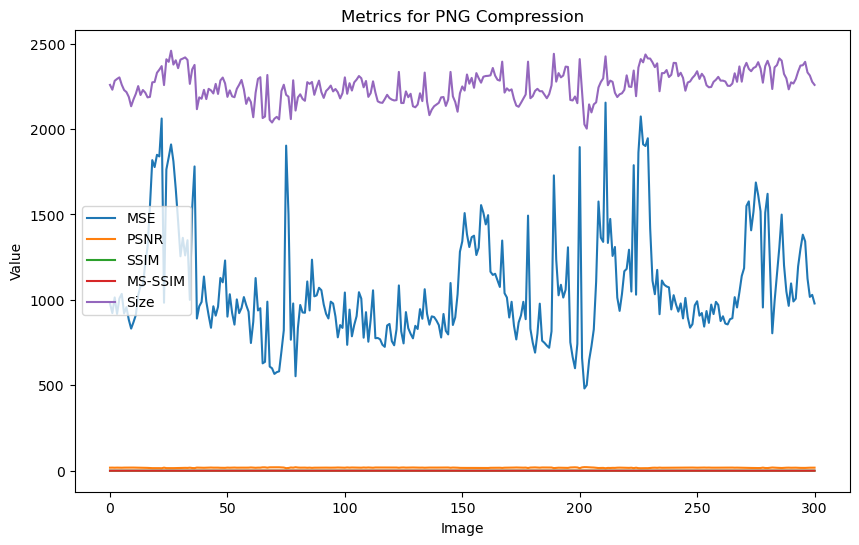

In [80]:
processor.plot_metrics('results.csv')

In [21]:
compressor = ImageCompressor(32, 32)
compressor.compress('Testing/CityUncompressed.jpg', 'compressed_image.jpg', 'JPEG', 50)
print(compressor.get_size('Testing/CityUncompressed.jpg'))
print(compressor.get_size('compressed_image.jpg'))

9011
492


In [28]:
metrics = ImageQualityMetrics('Testing/CityUncompressed.jpg', 'compressed_image.jpg')
print(metrics.calculate_mse())
print(metrics.calculate_psnr())
print(metrics.calculate_ssim())
print(metrics.calculate_msssim())

1335.6989135742188
16.873717881399333
0.5551615580233958
0.5487545778377035


In [41]:
compressor = ImageCompressor(32, 32)
results = compressor.pipeline('Testing/CityUncompressed.jpg', 'compressed_image.jpg', 32, 32, 'JPEG', 50)
print(results)

[1335.6989135742188, 16.873717881399333, 0.5551615580233958, 0.5487545778377035, 492]
